In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def integrate_standard_map(xo,wo,tf,k=0.5):
    '''
    Args:
        xo (2d arr): vector of initial (xt,yt)
        wo (2d arr): vector of initial (w1t,w2t)
        tf (flt): fiinal time to integrate to
        k (flt): non-linearity parameter
    '''
    twopi = 2*np.pi
    xt = xo[0]
    yt = xo[1]
    w1t = wo[0]
    w2t = wo[1]
    for t in range(1,tf):
        x_tplus1 = xt + yt - (k/twopi)*np.sin(twopi*xt)
        y_tplus1 = yt - (k/twopi)*np.sin(twopi*xt)
        w1_tplus1 = (1 - k*np.cos(twopi*xt)) * w1t + w2t
        w2_tplus1 = (-k*np.cos(twopi*xt)) * w1t + w2t
        xt = x_tplus1
        yt = y_tplus1
        w1t = w1_tplus1
        w2t = w2_tplus1
    return (xt,yt), (w1t,w2t)
        

In [3]:
xs = np.linspace(-0.5,0.5,500)
ys = np.linspace(-0.5,0.5,500)
FLI_sm = np.zeros((len(xs),len(ys)))
FLIB_sm = np.zeros((len(xs),len(ys)))


for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        # original plot:
        xbar,wbar = integrate_standard_map((x,y),(0.5,0.5),100,k = 0.9)
        FLI_sm[j,i] = np.log10(np.linalg.norm(wbar))
        # FLI refinements:
        e1 = (1,0)
        e2 = (0,1)
        xbar1,wbar1 = integrate_standard_map((x,y),e1,100,k = 0.9)  
        xbar2,wbar2 = integrate_standard_map((x,y),e2,100,k = 0.9) 
        FLIB_sm[j,i] = np.max([np.log10(np.linalg.norm(wbar1)),\
                               np.log10(np.linalg.norm(wbar2))])
        # apply supremum:
        if FLIB_sm[j,i] < 0:
            FLIB_sm[j,i] = 0

<IPython.core.display.Javascript object>


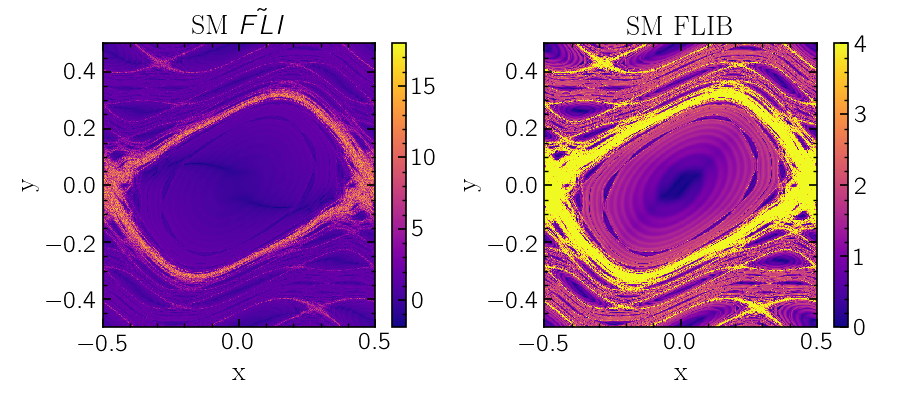

In [9]:
from matplotlib.colors import Normalize
# Thresholding:
norm = Normalize(vmin=0, vmax=4)
# Plot:
%matplotlib notebook
plt.figure(figsize=(9,4))
plt.subplot(121)
cbar = plt.pcolormesh(xs,ys,FLI_sm, cmap = 'plasma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'SM $\tilde{FLI}$')

plt.subplot(122)
cbar = plt.pcolormesh(xs,ys,FLIB_sm, cmap = 'plasma', norm=norm)
cbar.set_clim(0, 4)
plt.colorbar(cbar)
plt.xlabel('x')
plt.ylabel('y')
plt.title('SM FLIB')
plt.tight_layout()

In [5]:
def g0(t,x,y,w1,w2,omega = 1):
    return y
def g1(t,x,y,w1,w2,omega = 1):
    return -omega**2 * np.sin(x)
def g2(t,x,y,w1,w2,omega = 1):
    return w2
def g3(t,x,y,w1,w2,omega = 1):
    return -w1 * omega**2 * np.cos(x)

def RK4(x_vector, f_vector, h):
    ''' Compute 4th order Runge-Kutta for a set of n-coupled ODEs
    Args:
        x_vector ((n+1)x1 arr): vector of iterating parameter (e.g. x or t) and n ODE parameters
        f_vector (nx1 arr): vector of ODE functions for each of n parameters
        h (flt): step size
    '''
    k0 = np.zeros(len(x_vector)-1)
    k1 = np.zeros(len(x_vector)-1)
    k2 = np.zeros(len(x_vector)-1)
    k3 = np.zeros(len(x_vector)-1)
    new_x_vector = np.zeros(len(x_vector))
    for i in range(len(x_vector)-1):
        k0[i] = h*f_vector[i](*x_vector)
    for i in range(len(x_vector)-1):
        k1[i] = h*f_vector[i](x_vector[0]+0.5*h, *x_vector[1:]+0.5*k0)
    for i in range(len(x_vector)-1):
        k2[i] = h*f_vector[i](x_vector[0]+0.5*h, *x_vector[1:]+0.5*k1)
    for i in range(len(x_vector)-1):
        k3[i] = h*f_vector[i](x_vector[0]+h, *x_vector[1:]+k1)
    new_x_vector[0] = x_vector[0] + h
    new_x_vector[1:] = x_vector[1:] + (1/6)*(k0+2*k1+2*k2+k3)
    return new_x_vector
    
def integrate_pendulum(x0, w0, tf, t0 = 0, h = 1e-3):
    '''
    Args:
        x0 (2d arr): vector of initial (phi,I)
        w0 (2d arr): vector of initial (w1,w2)
        tf (flt): final time to integrate to
        t0 (flt): initial time.  Default = 0
        h (flt): RK4 step size.  Default = 1e-3
    '''
    t = t0
    xo = x0[0]
    yo = x0[1]
    w1o = w0[0]
    w2o = w0[1]
    x0_vector = np.array([t0,xo,yo,w1o,w2o],dtype=object)
    f = np.array([g0,g1,g2,g3])
    xbar = x0_vector
    while t < tf:
        new_x = RK4(xbar, f, h)
        t = new_x[0]
        xbar = new_x
    return xbar


In [6]:
from cliotools.bditools import update_progress
phis = np.linspace(0,2*np.pi,200)
Is = np.linspace(-2,2,200)
FLI_pend = np.zeros((len(phis),len(Is)))
    
FLIB_pend = np.zeros((len(phis),len(Is)))

for i,phi in enumerate(phis):
    for j,I in enumerate(Is):
        # Original solution:
        xbar = integrate_pendulum((phi,I),(0.5,0.5),100, h=1e-1)    
        wbar = xbar[3:]
        FLI_pend[j,i] = np.log10(np.linalg.norm(wbar))
        # FLI improvements:
        e1 = (1,0)
        e2 = (0,1)
        xbar = integrate_pendulum((phi,I),e1,100, h=1e-1) 
        wbar1 = xbar[3:]
        xbar = integrate_pendulum((phi,I),e2,100, h=1e-1) 
        wbar2 = xbar[3:]
        FLIB_pend[j,i] = np.max([np.log10(np.linalg.norm(wbar1)),\
                                 np.log10(np.linalg.norm(wbar2))])
        # apply supremum:
        if FLIB_pend[j,i] < 0:
            FLIB_pend[j,i] = 0
    update_progress(i+1,len(phis))

100% (199 of 200): |####################|  Done...
100% (200 of 200): |####################|  Done...


<IPython.core.display.Javascript object>


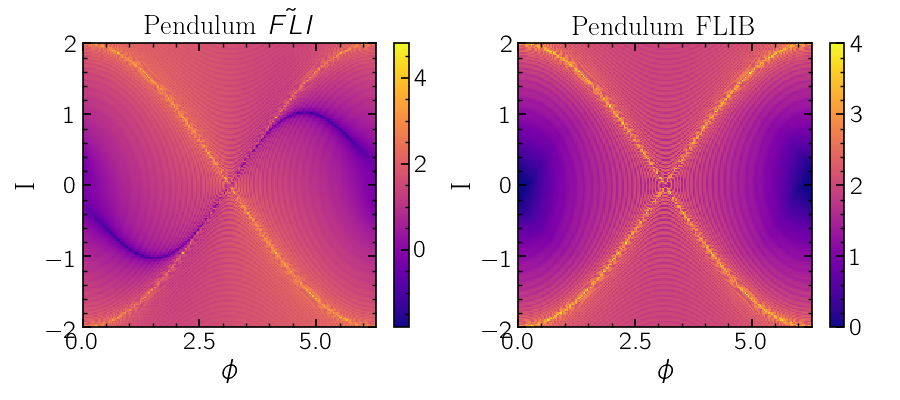

In [7]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=4)
%matplotlib notebook
plt.figure(figsize=(9,4))
plt.subplot(121)
cbar = plt.pcolormesh(phis,Is,FLI_pend, cmap = 'plasma')
plt.colorbar()
plt.xlabel(r'$\phi$')
plt.ylabel('I')
plt.title(r'Pendulum $\tilde{FLI}$')

plt.subplot(122)
cbar = plt.pcolormesh(phis,Is,FLIB_pend, cmap = 'plasma', norm=norm)
cbar.set_clim(0, 4)
plt.colorbar(cbar)
plt.xlabel(r'$\phi$')
plt.ylabel('I')
plt.title('Pendulum FLIB')
plt.tight_layout()